In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2, mean_squared_error
from sklearn.metrics import recall_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings. filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize = (18,10))

    plt.subplot(121)
    sns.scatterplot(x = train_pred_values, y = train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.subplot(122)
    sns.scatterplot(x = test_pred_values, y = test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show( )

In [5]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

__Описания полей датасета по недвижимости:__<br>
Id - идентификационный номер квартиры<br>
DistrictId - идентификационный номер района<br>
Rooms - количество комнат<br>
Square - площадь<br>
LifeSquare - жилая площадь<br>
KitchenSquare - площадь кухни<br>
Floor - этаж<br>
HouseFloor - количество этажей в доме<br>
HouseYear - год постройки дома<br>
Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности<br>
Social_1, Social_2, Social_3 - социальные показатели местности<br>
Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья<br>
Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров<br>
Price - цена квартиры.

__Цель:__<br>
Используя данные датасета по недвижимости, построить модель для предсказания цен на недвижимость (квартиры).<br>
С помощью полученной модели предсказать цены для квартир из файла test.csv.<br>
Целевая переменная: __Price__

In [6]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, index_col='Id')
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH, index_col='Id')
test_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [8]:
train_df.shape, test_df.shape

((10000, 19), (5000, 18))

# __Подготовка данных__

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

__Видно, что есть пропуски у признаков LifeSquare и Healthcare_1, которые нужно обработать. Признаки Id и DistrictId переделать в строковый тип.__

In [10]:
train_df['DistrictId'].value_counts() # Проверил и убедился, что признак категориальный.

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
117      1
174      1
205      1
209      1
Name: DistrictId, Length: 205, dtype: int64

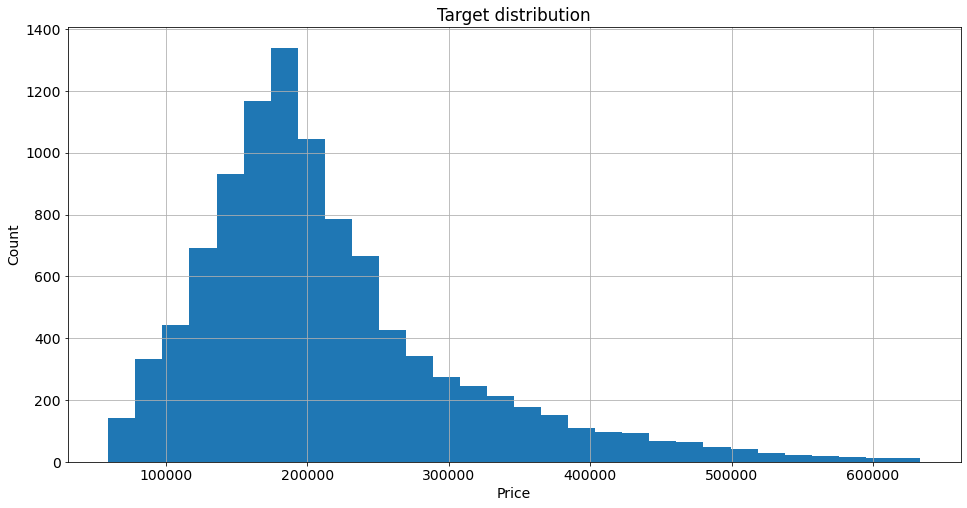

In [11]:
# Распределение целевой переменной Price
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

Плавное распределение, выбросов сильных нет

In [12]:
train_df.describe(include = "all")

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,B,NaN,NaN,NaN,NaN,NaN,NaN,B,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9903,9725,NaN,NaN,NaN,NaN,NaN,NaN,9175,NaN
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,NaN,NaN,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,NaN,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,NaN,NaN,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,NaN,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,NaN,NaN,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,NaN,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,NaN,NaN,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,NaN,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,NaN,NaN,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,NaN,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,NaN,NaN,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,NaN,249135.462171


__Из анализа выше видно, что в признаках есть не соответствие:<br> 
Rooms - есть выброс;<br> 
HouseFloor - минимальное значение в них не должны быть 0;<br> 
LifeSquare > Square - не соответствует действительности;<br> 
HouseYear - имеется слишком большое значение.__<br> 

### __Матрица коррелиций__

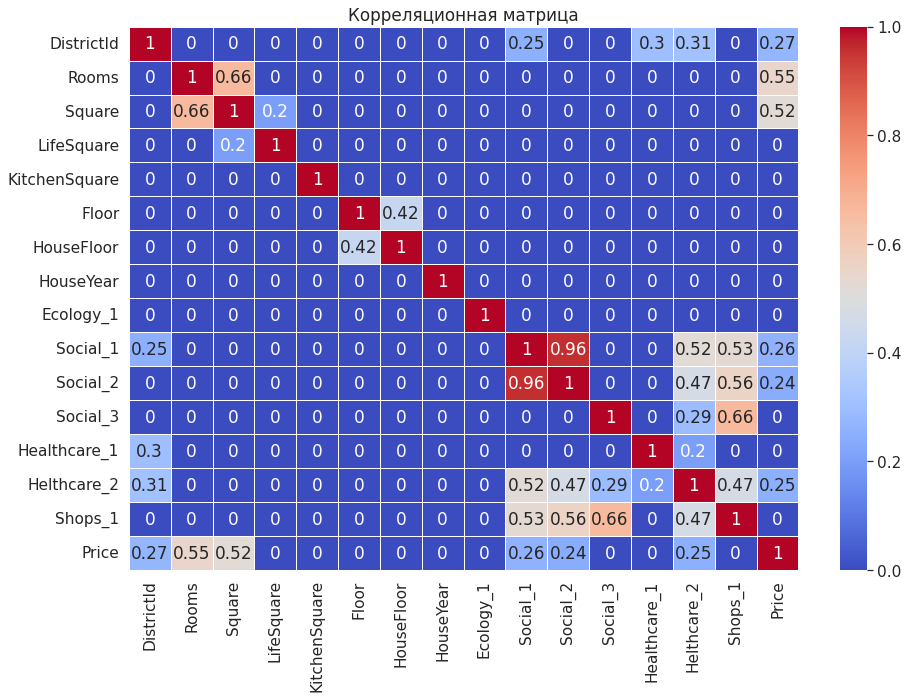

In [13]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.19] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Корреляционная матрица')
plt.show()

__Имеется сильная корреляция между количеством комнат с стоимостью и общей площадью, этаж и этажность дома, Helthcare_2 и Shops_1.__

In [14]:
# Привел данные в строковый тип
train_df['DistrictId'] = train_df['DistrictId'].astype(str) 
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [15]:
train_df['Ecology_2'].value_counts() # Категориальный признак. 

B    9903
A      97
Name: Ecology_2, dtype: int64

In [16]:
train_df['Ecology_3'].value_counts() # Категориальный признак. 

B    9725
A     275
Name: Ecology_3, dtype: int64

In [17]:
train_df['Shops_2'].value_counts() # Категориальный признак. 

B    9175
A     825
Name: Shops_2, dtype: int64

In [18]:
# Перевел категориальные объекты в числовые.
train_df[['Ecology_2', 'Ecology_3', 'Shops_2']] = train_df[['Ecology_2', 'Ecology_3', 'Shops_2']].replace({'A':0, 'B':1})
test_df[['Ecology_2', 'Ecology_3', 'Shops_2']] = test_df[['Ecology_2', 'Ecology_3', 'Shops_2']].replace({'A':0, 'B':1})

## __Заполнение недостающих данных__

In [19]:
train_df.isna().sum()[train_df.isna().sum() != 0]

LifeSquare      2113
Healthcare_1    4798
dtype: int64

In [20]:
# Заполнил 'LifeSquare' разностью между общей площадью и площадью кухни, 
# такое решение считаю более рельным и оно не сильно выделяется на фоне остальных данных.
train_df.loc[train_df['LifeSquare'].isna(), 'LifeSquare'] = \
    train_df['Square'] - train_df['KitchenSquare']
test_df.loc[test_df['LifeSquare'].isna(), 'LifeSquare'] = \
    test_df['Square'] - test_df['KitchenSquare']

In [21]:
train_df['Healthcare_1'].value_counts() # Категориальный признак. 

540.0     511
30.0      348
1046.0    245
750.0     163
229.0     148
         ... 
370.0      14
32.0       12
1815.0     10
35.0        2
0.0         1
Name: Healthcare_1, Length: 79, dtype: int64

In [22]:
# Признак 'Healthcare_1' заполнил медианным значением.
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

## __Обработка аномальных значений__

<h3 style="text-align: center;">Rooms - количество комнат</h3>

In [23]:
# Признак категориальный, видно что все то, что ниже 5 комнат скарей всего выбрас.
train_df['Rooms'].value_counts() 

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [24]:
# Выбрасов по комнатом совсем не много, не стал удалять, а заменил эти данные медианой.
train_df.loc[(train_df['Rooms'] > 5)|(train_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].median()
test_df.loc[(test_df['Rooms'] > 5)|(test_df['Rooms'] == 0), 'Rooms'] = train_df['Rooms'].median()

<h3 style="text-align: center;">Square, LifeSquare, KitchenSquare - площади</h3>

In [25]:
# Ниже в статистике видно, что еть неестетвенное соответствие в распределении площади
train_df[['Square', 'LifeSquare', 'KitchenSquare']].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.315775,41.799474,6.273300
std,21.058732,77.823543,28.560917
min,1.136859,0.370619,0.000000
25%,41.774881,25.494155,1.000000
50%,52.513310,37.040829,6.000000
75%,65.900625,49.823229,9.000000
max,641.065193,7480.592129,2014.000000


__KitchenSquare__

In [26]:
# Выбрал не соответствующие параметры кухни.
train_df.loc[(train_df['KitchenSquare'] > train_df['Square']), :]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,1,1,2,629,1,900.0,0,0,0,108337.484207
13703,42,1.0,38.071692,19.723548,73.0,9,10.0,2006,0.158249,1,1,21,5731,0,900.0,1,0,1,160488.033165
6569,27,1.0,38.220258,18.716856,84.0,4,17.0,2018,0.011654,1,1,4,915,0,900.0,0,0,1,99079.960518
14679,81,1.0,32.276663,19.278394,1970.0,6,1.0,1977,0.006076,1,1,30,5285,0,645.0,6,6,1,105539.556275


In [27]:
# Заменил несоответствующие параметры медианой.
train_df.loc[(train_df['KitchenSquare'] > train_df['LifeSquare']),
             'KitchenSquare'] = train_df['LifeSquare'] - train_df['Square']

test_df.loc[(test_df['KitchenSquare'] > test_df['LifeSquare']),
             'KitchenSquare'] = test_df['LifeSquare'] - test_df['Square']

__Square__

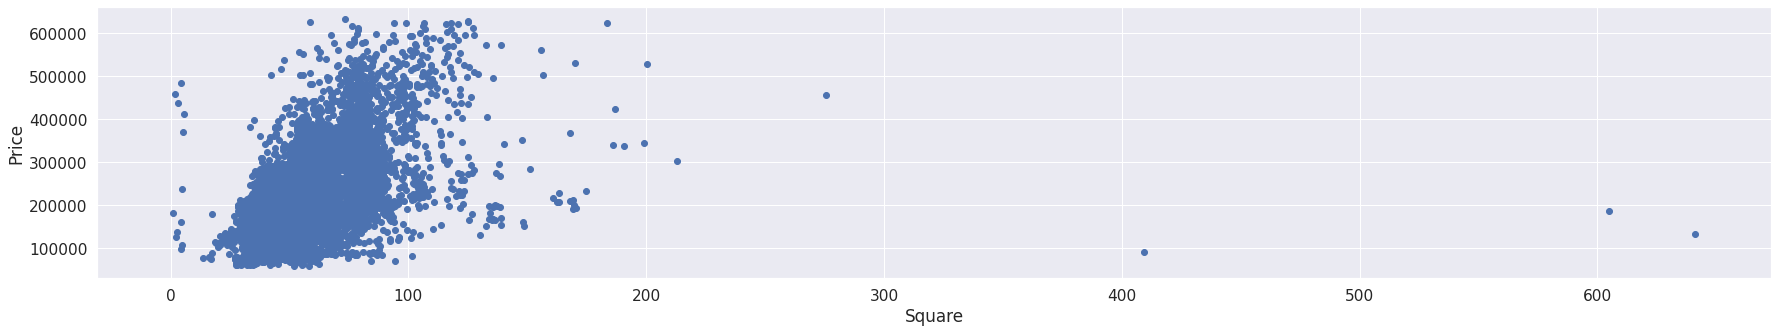

In [28]:
fig, ax = plt.subplots(figsize = (30,5))
ax.scatter(train_df['Square'], train_df['Price'])
ax.set_xlabel('Square')
ax.set_ylabel('Price')
plt.show()

In [29]:
train_df.loc[(train_df['Square'] > 400) | (train_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

test_df.loc[(test_df['Square'] > 400) | (test_df['Square'] < 10), 'Square'] = \
            train_df['Square'].median()

__LifeSquare__

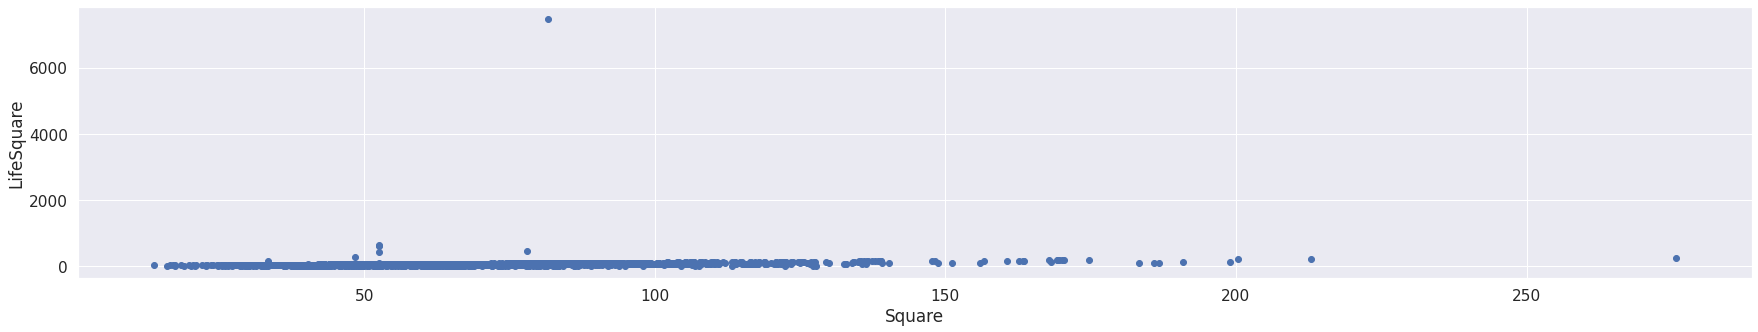

In [30]:
fig, ax = plt.subplots(figsize = (30,5))
ax.scatter(train_df['Square'], train_df['LifeSquare'])
ax.set_xlabel('Square')
ax.set_ylabel('LifeSquare')
plt.show()

In [31]:
# Квартиры, в которых жилая площадь больше общей, являются выбросами. Их необходимо обработать
train_df.loc[(train_df['LifeSquare'] > train_df['Square']), 'LifeSquare'] = \
        train_df['Square']
test_df.loc[(test_df['LifeSquare'] > test_df['Square']), 'LifeSquare'] = \
        test_df['Square']

<h3 style="text-align: center;">HouseFloor - количество этажей в доме</h3>

In [32]:
# Нулевую этажность заменил на медианное значение
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

<h3 style="text-align: center;">Floor - этаж</h3>

In [33]:
# Исправил выбрасы по этажам
floor_outliers_train = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers_test = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index

In [34]:
train_df.loc[floor_outliers_train, 'Floor'] = \
    train_df.loc[floor_outliers_train, 'HouseFloor'].apply(lambda x: random.randint(1, x))
test_df.loc[floor_outliers_test, 'Floor'] = \
    test_df.loc[floor_outliers_test, 'HouseFloor'].apply(lambda x: random.randint(1, x))

<h3 style="text-align: center;">HouseYear - год постройки дома</h3>

In [35]:
# Исправил выбрасы по годам.
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

# __Построение новых признаков__

In [36]:
print(train_df['DistrictId'].nunique(), ' уникальных  значений в train')
print(test_df['DistrictId'].nunique(), ' уникальных  значений в test')

205  уникальных  значений в train
201  уникальных  значений в test


#### __DistrictSize__

In [37]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,207,1
201,117,1
202,174,1
203,205,1


In [38]:
districts_popular = district_size.loc[district_size['DistrictSize'] > 100, 'DistrictId'].tolist()

district_size.loc[~district_size['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
district_size = district_size.groupby('DistrictId')['DistrictSize'].agg(
                            DistrictSize='median')
district_size.reset_index(level='DistrictId', inplace=True)
district_size.head()

,DistrictId,DistrictSize
0,999,15.0
1,1,652.0
2,11,129.0
3,21,165.0
4,23,565.0


In [39]:
train_df.loc[~train_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999
test_df.loc[~test_df['DistrictId'].isin(districts_popular), 'DistrictId'] = 999

In [40]:
train_df = train_df.merge(district_size, on='DistrictId', how='left').set_index(train_df.index)
test_df = test_df.merge(district_size, on='DistrictId', how='left').set_index(test_df.index)
train_df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
Id,,,,,,,,,,,,,,,,,,,,
14038,999,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,900.0,0,11,1,184966.930730,15.0
15053,999,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063,15.0
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524,174.0
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217,179.0
10783,999,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644,15.0


#### __PriceOneRoomByDistrict__

In [41]:
train_df['PriceOneRoom'] = train_df['Price'] / train_df['Rooms']

In [42]:
price_by_district = train_df.groupby(['DistrictId'], as_index=False)\
                        .agg({'PriceOneRoom':'median'})\
                        .rename(columns={'PriceOneRoom':'PriceOneRoomByDistrict'})

price_by_district.head()

,DistrictId,PriceOneRoomByDistrict
0,999,129339.268164
1,1,106080.898140
2,11,100098.984216
3,21,104448.247925
4,23,76232.424372


In [43]:
train_df = train_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(train_df.index)
test_df = test_df.merge(price_by_district, on=['DistrictId'], how='left').set_index(test_df.index)

In [44]:
train_df = train_df.drop(['PriceOneRoom'], axis=1)

#### __RoomSquare__

In [45]:
train_df['RoomSquare'] = train_df['Square'] / train_df['Rooms']
test_df['RoomSquare'] = test_df['Square'] / test_df['Rooms']

# __Анализ данных__

In [46]:
feature_names = train_df.columns
feature_names.tolist()

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'PriceOneRoomByDistrict',
 'RoomSquare']

In [47]:
target_names = 'Price'
feature_names = ['DistrictId',
                 'Rooms',
                 'Square',
                 'LifeSquare',
                 'KitchenSquare',
                 'Floor',
                 'HouseFloor',
                 'HouseYear',
                 'Ecology_1',
                 'Ecology_2',
                 'Ecology_3',
                 'Social_1',
                 'Social_2',
                 'Social_3',
                 'Healthcare_1',
                 'Helthcare_2',
                 'Shops_1',
                 'Shops_2',
                 'DistrictSize',
                 'PriceOneRoomByDistrict',
                 'RoomSquare']

In [48]:
X = train_df[feature_names]
y = train_df[target_names]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### __Случайный лес__

In [50]:
rf_model = RandomForestRegressor(max_depth=15,
                                    max_features=9,
                                    random_state=21)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, max_features=9, random_state=21)

In [51]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

Train R2:	0.938
Test R2:	0.736


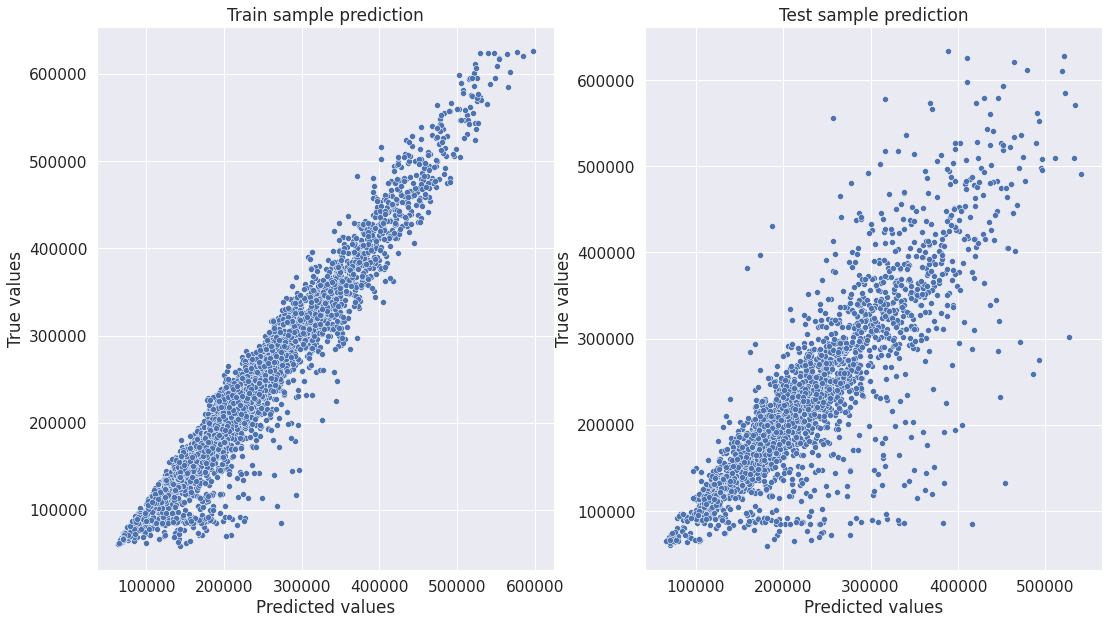

In [52]:
evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [53]:
cv_score = cross_val_score(rf_model, X, y, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.73423511, 0.72722497, 0.75193772])

In [54]:
cv_score.mean()

0.7377992672531674

### __Линейная регрессия__

In [55]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
predictions = linear_regression.predict(X_test)

lr = cross_val_score(linear_regression, X, y, cv=10, scoring="r2").mean()
lr

0.6006570794592163

In [56]:
cv_score.mean() > lr

True

Случайный лес показал лутше результат

### __Важность признаков__

In [57]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False).head()

,feature_name,importance
2,Square,0.306938
1,Rooms,0.108446
19,PriceOneRoomByDistrict,0.094697
18,DistrictSize,0.064917
3,LifeSquare,0.063879


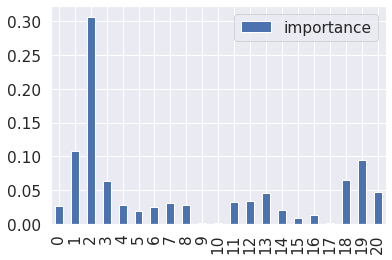

In [58]:
feature_importances.plot.bar()
plt.show()

__Вывод__ - подготовили данные, поправил выбрасы и заполнил недастоющие данные, наилучшая модель - дерево решений с максимальной глубиной в 9. r2 составил 0.73.
Большое значение на влияние цены играют таки факторы, как площадь кавартиры и кооличество комнат и в меньшей степени район.

In [59]:
forest_best = RandomForestRegressor(max_depth=15,
                                    max_features=5,
                                    random_state=21)
forest_best.fit(X, y)
y_pred = forest_best.predict(test_df[feature_names])
y_pred

array([165628.10725566, 232625.24537978, 236824.22000295, ...,
       320508.92984901, 196176.18444004, 174069.916303  ])

In [60]:
preds = pd.DataFrame()
preds['Id'] = test_df.index
preds['Price'] = y_pred
preds.head()

,Id,Price
0,725,165628.107256
1,15856,232625.245380
2,5480,236824.220003
3,15664,340063.496124
4,14275,143379.338498


In [61]:
preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


In [62]:
preds.to_csv('DRudenko_predictions.csv', index=False)